In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import logging

# 1. Load Data

In [3]:
def init_logger():
    # create logger
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)

    # create formatter
    formatter = logging.Formatter('%(levelname)s - %(message)s')

    # add formatter to ch
    ch.setFormatter(formatter)

    # add ch to logger
    logger.addHandler(ch)
    return logger

In [4]:
logger = init_logger()
base=os.environ['HOME']

In [5]:
location='Documents/Github/quant_exercises/hopper/'

In [6]:
fname='HPF Sample Data.csv'

In [7]:
def read_data(location,filename):
    """read the data"""
    df = pd.read_csv(os.path.join(location,filename),
                     delimiter=',',
                     dtype = { 
                         'offer_id': str,
                         'prediction_date' : str,
                         'check_in': str,
                         'check_out': str,
                         'advance': np.int64,
                         'address_city':str,
                         'deposit_total_usd':np.float64,
                         'duration':np.float64,
                         'premium_percent': str,
                         'frozen_price_total_usd':np.float64,
                         'purchased':str,
                         'exercised':str,
                         'capped_otm_amount_usd':str,
                         'pf_refunded':str,
                         'cap_total_usd': np.float64
                     }
                    )
    logger.info('read %s',os.path.join(filename))
    return df

In [8]:
df=read_data(os.path.join(base,location),fname)

INFO - read HPF Sample Data.csv


In [9]:
df.head()

,offer_id,prediction_date,check_in,check_out,advance,address_city,deposit_total_usd,duration,premium_percent,frozen_price_total_usd,purchased,exercised,capped_otm_amount_usd,pf_refunded,cap_total_usd,Days
0,f5a27949-a8cf-4da2-ae73-e8064207d491,2022-09-23,2022-09-27,2022-09-29,3,Palmerston North,22.0,1.0,9.80%,224.49,NaN,NaN,NaN,NaN,200.0,NaN
1,6f8d0f29-c3c9-4016-be0d-b2d78fcae9f3,2022-09-23,2022-09-26,2022-09-28,3,Johannesburg,72.0,1.0,33.85%,212.69,NaN,NaN,NaN,NaN,200.0,NaN
2,916bd00f-cfd8-49ac-9a1e-488294c8d920,2022-09-23,2022-09-28,2022-09-30,5,Aqaba,140.0,3.0,10.50%,1333.79,NaN,NaN,NaN,NaN,200.0,NaN
3,3d451e86-b005-4336-9d37-b32d9422246c,2022-09-23,2022-11-01,2022-11-02,39,ミラノ,31.0,3.0,28.78%,107.71,NaN,NaN,NaN,NaN,200.0,NaN
4,abd10aa4-c8ec-4913-882b-84c08f7acb27,2022-09-23,2022-12-06,2022-12-07,74,Florianópolis,3.0,3.0,17.11%,17.54,NaN,NaN,NaN,NaN,200.0,NaN


# 2. Analyze Data

## 2.1 Change data types

In [10]:
df['purchased']=pd.to_numeric(df['purchased'])

In [11]:
df['exercised']=pd.to_numeric(df['exercised'])

In [12]:
df['capped_otm_amount_usd']=pd.to_numeric(df['capped_otm_amount_usd'],downcast='signed')

In [13]:
df['pf_refunded']=pd.to_numeric(df['pf_refunded'])

In [14]:
df['check_in']=pd.to_datetime(df['check_in'],yearfirst=True,format='%Y-%m-%d')
df['check_out']=pd.to_datetime(df['check_out'],yearfirst=True,format='%Y-%m-%d')
df['prediction_date']=pd.to_datetime(df['prediction_date'],yearfirst=True,format='%Y-%m-%d')

In [15]:
df['Days']=df['check_out']-df['check_in']

In [16]:
df['premium_percent']=df['deposit_total_usd']/df['frozen_price_total_usd']

In [17]:
df.rename(columns={"Days":"stay_duration"},inplace=True)

In [18]:
exclude = (df['premium_percent']<=1.0)
#df[(df['premium_percent']>1.0)]
df_final=df[exclude].copy()

In [19]:
logger.info("create categories of continuous variables")
df_final['advance_category']=pd.cut(df_final['advance'],bins=6)
df_final['premium_category']=pd.cut(df_final['premium_percent'],bins=6)
df_final['cap_total_category']=pd.cut(df_final['cap_total_usd'],bins=6)
df_final['stay_duration_category']=pd.cut(df_final['stay_duration'],bins=9)
df_final['capped_otm_amount_category']=pd.cut(df_final['capped_otm_amount_usd'],bins=6)

INFO - create categories of continuous variables


In [20]:
# extract month of prediction
df_final['prediction_month']=df_final['prediction_date'].dt.month

In [21]:
# create transformed purchased variable
df_final['purchased_calc']=df_final['purchased']
df_final.loc[df_final['purchased']!=1,'purchased_calc']=0

In [22]:
# create transformed capped otm variable
df_final['capped_otm_amount_usd_calc']=df_final['capped_otm_amount_usd'].apply(lambda x: x if x<=0 else 0)

In [23]:
df_final.describe()

,prediction_date,check_in,check_out,advance,deposit_total_usd,duration,premium_percent,frozen_price_total_usd,purchased,exercised,capped_otm_amount_usd,pf_refunded,cap_total_usd,stay_duration,prediction_month,purchased_calc,capped_otm_amount_usd_calc
count,252287,252287,252287,252287.000000,252287.000000,252287.000000,252287.000000,252287.000000,5752.0,5752.000000,1273.000000,5752.000000,252287.000000,252287,252287.000000,252287.000000,252287.000000
mean,2022-10-20 06:09:53.581120,2022-11-14 05:23:10.145350144,2022-11-16 10:09:18.706552320,24.922505,61.021535,3.641607,0.193004,381.190994,1.0,0.221488,-13.771665,0.353790,195.804833,2 days 04:46:08.561202122,10.134153,0.022799,-0.069490
min,2022-09-23 00:00:00,2022-09-23 00:00:00,2022-09-24 00:00:00,1.000000,2.000000,0.500000,0.000835,2.810000,1.0,0.000000,-321.490000,0.000000,50.000000,1 days 00:00:00,9.000000,0.000000,-321.490000
25%,2022-10-04 00:00:00,2022-10-20 00:00:00,2022-10-22 00:00:00,3.000000,14.000000,1.000000,0.141930,76.770000,1.0,0.000000,-12.890000,0.000000,200.000000,1 days 00:00:00,10.000000,0.000000,0.000000
50%,2022-10-19 00:00:00,2022-11-06 00:00:00,2022-11-08 00:00:00,9.000000,30.000000,3.000000,0.194379,162.660000,1.0,0.000000,-0.920000,0.000000,200.000000,1 days 00:00:00,10.000000,0.000000,0.000000
75%,2022-11-05 00:00:00,2022-11-22 00:00:00,2022-11-25 00:00:00,24.000000,70.000000,7.000000,0.246018,367.410000,1.0,0.000000,0.000000,1.000000,200.000000,3 days 00:00:00,11.000000,0.000000,0.000000
max,2022-11-21 00:00:00,2023-11-15 00:00:00,2023-11-20 00:00:00,365.000000,6930.000000,7.000000,0.711744,251419.370000,1.0,2.000000,0.000000,1.000000,700.000000,90 days 00:00:00,11.000000,1.000000,0.000000
std,NaN,NaN,NaN,43.789483,103.482659,2.513875,0.073904,1245.036246,0.0,0.415703,31.273800,0.478187,49.988617,2 days 09:01:50.104105896,0.673568,0.149264,2.425571


In [24]:
df_final.head()

,offer_id,prediction_date,check_in,check_out,advance,address_city,deposit_total_usd,duration,premium_percent,frozen_price_total_usd,...,cap_total_usd,stay_duration,advance_category,premium_category,cap_total_category,stay_duration_category,capped_otm_amount_category,prediction_month,purchased_calc,capped_otm_amount_usd_calc
0,f5a27949-a8cf-4da2-ae73-e8064207d491,2022-09-23,2022-09-27,2022-09-29,3,Palmerston North,22.0,1.0,0.098000,224.49,...,200.0,2 days,"(0.636, 61.667]","(0.000124, 0.119]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,0.0,0.0
1,6f8d0f29-c3c9-4016-be0d-b2d78fcae9f3,2022-09-23,2022-09-26,2022-09-28,3,Johannesburg,72.0,1.0,0.338521,212.69,...,200.0,2 days,"(0.636, 61.667]","(0.238, 0.356]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,0.0,0.0
2,916bd00f-cfd8-49ac-9a1e-488294c8d920,2022-09-23,2022-09-28,2022-09-30,5,Aqaba,140.0,3.0,0.104964,1333.79,...,200.0,2 days,"(0.636, 61.667]","(0.000124, 0.119]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,0.0,0.0
3,3d451e86-b005-4336-9d37-b32d9422246c,2022-09-23,2022-11-01,2022-11-02,39,ミラノ,31.0,3.0,0.287810,107.71,...,200.0,1 days,"(0.636, 61.667]","(0.238, 0.356]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,0.0,0.0
4,abd10aa4-c8ec-4913-882b-84c08f7acb27,2022-09-23,2022-12-06,2022-12-07,74,Florianópolis,3.0,3.0,0.171038,17.54,...,200.0,1 days,"(61.667, 122.333]","(0.119, 0.238]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,0.0,0.0


In [25]:
df_final.loc[(df_final['purchased']==1)].head()

,offer_id,prediction_date,check_in,check_out,advance,address_city,deposit_total_usd,duration,premium_percent,frozen_price_total_usd,...,cap_total_usd,stay_duration,advance_category,premium_category,cap_total_category,stay_duration_category,capped_otm_amount_category,prediction_month,purchased_calc,capped_otm_amount_usd_calc
4254,4a24b8d1-0393-4114-a9e0-762e88ec9556,2022-09-23,2022-09-25,2022-09-26,2,東京,8.0,0.5,0.083377,95.95,...,200.0,1 days,"(0.636, 61.667]","(0.000124, 0.119]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,1.0,0.0
4255,8dcdfd66-6742-4c5a-aab6-459cc0899c38,2022-09-23,2022-09-26,2022-09-30,3,Okinawa Main island,32.0,1.0,0.134476,237.96,...,200.0,4 days,"(0.636, 61.667]","(0.119, 0.238]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,1.0,0.0
4256,63a70c37-a9c9-4ee1-bb76-ad7e35a73ce3,2022-09-23,2022-09-26,2022-10-01,3,Koh Samet,290.0,1.0,0.357209,811.85,...,200.0,5 days,"(0.636, 61.667]","(0.356, 0.475]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,1.0,0.0
4257,a81718e2-6531-442b-8b2c-b4ec9731e1cf,2022-09-23,2022-09-26,2022-09-27,3,大阪,2.0,1.0,0.060078,33.29,...,200.0,1 days,"(0.636, 61.667]","(0.000124, 0.119]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,1.0,0.0
4258,ae6eed8a-8a1b-4523-8a13-a88d64e9622f,2022-09-23,2022-09-23,2022-09-25,1,Lakeland (FL),34.0,0.5,0.191960,177.12,...,200.0,2 days,"(0.636, 61.667]","(0.119, 0.238]","(158.333, 266.667]","(0 days 21:51:50.400000, 10 days 21:20:00]",NaN,9,1.0,0.0


In [26]:
df_final.columns

Index(['offer_id', 'prediction_date', 'check_in', 'check_out', 'advance',
       'address_city', 'deposit_total_usd', 'duration', 'premium_percent',
       'frozen_price_total_usd', 'purchased', 'exercised',
       'capped_otm_amount_usd', 'pf_refunded', 'cap_total_usd',
       'stay_duration', 'advance_category', 'premium_category',
       'cap_total_category', 'stay_duration_category',
       'capped_otm_amount_category', 'prediction_month', 'purchased_calc',
       'capped_otm_amount_usd_calc'],
      dtype='object')

## 2.2 EDA Analysis

In [27]:
df_final.groupby(by='stay_duration_category')['offer_id'].count()

stay_duration_category
(0 days 21:51:50.400000, 10 days 21:20:00]    249813
(10 days 21:20:00, 20 days 18:40:00]            1844
(20 days 18:40:00, 30 days 16:00:00]             490
(30 days 16:00:00, 40 days 13:20:00]              82
(40 days 13:20:00, 50 days 10:40:00]              19
(50 days 10:40:00, 60 days 08:00:00]              16
(60 days 08:00:00, 70 days 05:20:00]              13
(70 days 05:20:00, 80 days 02:40:00]               0
(80 days 02:40:00, 90 days 00:00:00]              10
Name: offer_id, dtype: int64

In [28]:
df_final.groupby(by='prediction_month')['offer_id'].count()

prediction_month
9      42578
10    133286
11     76423
Name: offer_id, dtype: int64

In [29]:
df_final.groupby(by='cap_total_category')['offer_id'].count()

cap_total_category
(49.35, 158.333]       17690
(158.333, 266.667]    229540
(266.667, 375.0]        2197
(375.0, 483.333]        1547
(483.333, 591.667]       445
(591.667, 700.0]         868
Name: offer_id, dtype: int64

In [30]:
df_final.groupby(by='premium_category')['offer_id'].count()

premium_category
(0.000124, 0.119]     42166
(0.119, 0.238]       130356
(0.238, 0.356]        79041
(0.356, 0.475]          688
(0.475, 0.593]           27
(0.593, 0.712]            9
Name: offer_id, dtype: int64

In [31]:
df_final.groupby(by='duration')['offer_id'].count()

duration
0.5    44234
1.0    43077
3.0    52198
5.0    46252
7.0    66526
Name: offer_id, dtype: int64

In [32]:
df_final.groupby(by='capped_otm_amount_category')['offer_id'].count()

capped_otm_amount_category
(-321.811, -267.908]       1
(-267.908, -214.327]       1
(-214.327, -160.745]      12
(-160.745, -107.163]      18
(-107.163, -53.582]       54
(-53.582, 0.0]          1187
Name: offer_id, dtype: int64

In [33]:
logger.info("totals for purchased offers with payouts by premium category")
pd.crosstab(df_final["capped_otm_amount_category"],df_final["cap_total_category"],values=df_final['purchased_calc'],aggfunc='sum', margins=True)

INFO - totals for purchased offers with payouts by premium category


cap_total_category,"(49.35, 158.333]","(158.333, 266.667]","(266.667, 375.0]","(375.0, 483.333]","(483.333, 591.667]","(591.667, 700.0]",All
capped_otm_amount_category,,,,,,,
"(-321.811, -267.908]",0.0,0.0,0.0,0.0,0.0,1.0,1.0
"(-267.908, -214.327]",0.0,1.0,0.0,0.0,0.0,0.0,1.0
"(-214.327, -160.745]",0.0,12.0,0.0,0.0,0.0,0.0,12.0
"(-160.745, -107.163]",1.0,17.0,0.0,0.0,0.0,0.0,18.0
"(-107.163, -53.582]",1.0,52.0,0.0,1.0,0.0,0.0,54.0
"(-53.582, 0.0]",154.0,1020.0,8.0,2.0,2.0,1.0,1187.0
All,156.0,1102.0,8.0,3.0,2.0,2.0,1273.0


In [34]:
logger.info("totals for purchased offers with payouts by premium category")
pd.crosstab(df_final["capped_otm_amount_category"],df_final["cap_total_category"],values=df_final['purchased_calc'],aggfunc='sum', margins=True)

INFO - totals for purchased offers with payouts by premium category


cap_total_category,"(49.35, 158.333]","(158.333, 266.667]","(266.667, 375.0]","(375.0, 483.333]","(483.333, 591.667]","(591.667, 700.0]",All
capped_otm_amount_category,,,,,,,
"(-321.811, -267.908]",0.0,0.0,0.0,0.0,0.0,1.0,1.0
"(-267.908, -214.327]",0.0,1.0,0.0,0.0,0.0,0.0,1.0
"(-214.327, -160.745]",0.0,12.0,0.0,0.0,0.0,0.0,12.0
"(-160.745, -107.163]",1.0,17.0,0.0,0.0,0.0,0.0,18.0
"(-107.163, -53.582]",1.0,52.0,0.0,1.0,0.0,0.0,54.0
"(-53.582, 0.0]",154.0,1020.0,8.0,2.0,2.0,1.0,1187.0
All,156.0,1102.0,8.0,3.0,2.0,2.0,1273.0


In [35]:
logger.info("proportions for purchased offers with payouts by premium category")
pd.crosstab(df_final["capped_otm_amount_category"],df_final["premium_category"],values=df_final['purchased_calc'],
            aggfunc='sum', margins=True, normalize=True)

INFO - proportions for purchased offers with payouts by premium category


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
capped_otm_amount_category,,,,,,,
"(-321.811, -267.908]",0.000000,0.000000,0.000786,0.000000,0.000000,0.0,0.000786
"(-267.908, -214.327]",0.000786,0.000000,0.000000,0.000000,0.000000,0.0,0.000786
"(-214.327, -160.745]",0.001571,0.007070,0.000786,0.000000,0.000000,0.0,0.009427
"(-160.745, -107.163]",0.002357,0.007855,0.003928,0.000000,0.000000,0.0,0.014140
"(-107.163, -53.582]",0.008641,0.020424,0.012569,0.000786,0.000000,0.0,0.042419
"(-53.582, 0.0]",0.128044,0.525530,0.278083,0.000000,0.000786,0.0,0.932443
All,0.141398,0.560880,0.296151,0.000786,0.000786,0.0,1.000000


In [36]:
pd.crosstab(df_final["exercised"],df_final["premium_category"],values=df_final['purchased_calc'],aggfunc='sum', margins=True)

premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
exercised,,,,,,,
0.0,689.0,2462.0,1319.0,8.0,1.0,0.0,4479.0
1.0,180.0,714.0,376.0,1.0,1.0,0.0,1272.0
2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
All,869.0,3176.0,1696.0,9.0,2.0,NaN,5752.0


In [37]:
pd.crosstab(df_final["exercised"],df_final["premium_category"],values=df_final['purchased_calc'],aggfunc='sum',normalize=True, margins=True)

premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
exercised,,,,,,,
0.0,0.119784,0.428025,0.229312,0.001391,0.000174,0.0,0.778686
1.0,0.031293,0.124131,0.065369,0.000174,0.000174,0.0,0.221140
2.0,0.000000,0.000000,0.000174,0.000000,0.000000,0.0,0.000174
All,0.151078,0.552156,0.294854,0.001565,0.000348,0.0,1.000000


In [38]:
logger.info('purchase rates by exercise and premium category')
pd.crosstab(df_final["exercised"],df_final["premium_category"],values=df_final['purchased_calc'],aggfunc='sum', margins=True)

INFO - purchase rates by exercise and premium category


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
exercised,,,,,,,
0.0,689.0,2462.0,1319.0,8.0,1.0,0.0,4479.0
1.0,180.0,714.0,376.0,1.0,1.0,0.0,1272.0
2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
All,869.0,3176.0,1696.0,9.0,2.0,NaN,5752.0


In [39]:
pd.crosstab(df_final["exercised"],df_final["premium_category"],values=df_final['purchased_calc'],aggfunc='sum', normalize=True, margins=True)

premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
exercised,,,,,,,
0.0,0.119784,0.428025,0.229312,0.001391,0.000174,0.0,0.778686
1.0,0.031293,0.124131,0.065369,0.000174,0.000174,0.0,0.221140
2.0,0.000000,0.000000,0.000174,0.000000,0.000000,0.0,0.000174
All,0.151078,0.552156,0.294854,0.001565,0.000348,0.0,1.000000


In [40]:
logger.info("Refund rates by duration and premium category")
pd.crosstab(df_final["duration"],df_final["premium_category"],values=df_final['pf_refunded'],aggfunc='mean', margins=True)

INFO - Refund rates by duration and premium category


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]",All
duration,,,,,,
0.5,0.282828,0.325973,0.348739,0.333333,NaN,0.327396
1.0,0.353659,0.326855,0.391045,1.000000,1.0,0.352390
3.0,0.357143,0.336714,0.363934,1.000000,NaN,0.349749
5.0,0.356725,0.403050,0.369478,0.000000,NaN,0.384091
7.0,0.328571,0.347949,0.438066,1.000000,0.0,0.372250
All,0.334868,0.343829,0.380307,0.666667,0.5,0.353790


In [41]:
logger.info("total  refunds by duration and premium category")
pd.crosstab(df_final["duration"],df_final["premium_category"],values=df_final['pf_refunded'],aggfunc='sum', margins=True)

INFO - total  refunds by duration and premium category


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
duration,,,,,,,
0.5,56.0,310.0,166.0,1.0,0.0,0.0,533.0
1.0,58.0,185.0,131.0,1.0,1.0,0.0,376.0
3.0,70.0,166.0,111.0,1.0,0.0,0.0,348.0
5.0,61.0,185.0,92.0,0.0,0.0,0.0,338.0
7.0,46.0,246.0,145.0,3.0,0.0,0.0,440.0
All,291.0,1092.0,645.0,6.0,1.0,NaN,2035.0


In [42]:
logger.info("Proportional refunds by duration and premium category")
pd.crosstab(df_final["duration"],df_final["premium_category"],values=df_final['pf_refunded'],aggfunc='sum', margins=True, normalize=True)

INFO - Proportional refunds by duration and premium category


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
duration,,,,,,,
0.5,0.027518,0.152334,0.081572,0.000491,0.000000,0.0,0.261916
1.0,0.028501,0.090909,0.064373,0.000491,0.000491,0.0,0.184767
3.0,0.034398,0.081572,0.054545,0.000491,0.000000,0.0,0.171007
5.0,0.029975,0.090909,0.045209,0.000000,0.000000,0.0,0.166093
7.0,0.022604,0.120885,0.071253,0.001474,0.000000,0.0,0.216216
All,0.142998,0.536609,0.316953,0.002948,0.000491,0.0,1.000000


In [43]:
logger.info("Total deposits by duration and premium category in millions")
pd.crosstab(df_final["duration"],df_final["premium_category"],values=df_final['deposit_total_usd'],aggfunc='sum', margins=True)/1e6            

INFO - Total deposits by duration and premium category in millions


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
duration,,,,,,,
0.5,0.140648,0.828259,0.648438,0.003006,0.000030,0.000012,1.620393
1.0,0.260005,0.989332,0.831409,0.008982,0.000038,0.000002,2.089768
3.0,0.590261,1.656011,1.373782,0.017104,0.000028,0.000012,3.637198
5.0,0.571304,1.531209,1.274121,0.017358,0.000014,0.000004,3.394010
7.0,0.674236,2.311981,1.647817,0.019525,0.000012,0.000000,4.653571
All,2.236454,7.316792,5.775567,0.065975,0.000122,0.000030,15.394940


In [44]:
df_final.loc[(df_final['purchased']==1)].groupby(by='pf_refunded')['offer_id'].count()

pf_refunded
0.0    3717
1.0    2035
Name: offer_id, dtype: int64

## 2.3 Business Analysis

In [45]:
def calculate_proportion(df,grp_metric,sum_metric,count_metric):
    """calculate proportion given a grouping metric"""
    return df.groupby(by=grp_metric)[sum_metric].sum()/df.groupby(by=grp_metric)[count_metric].count()

### KPI 1: Proportion of Purchases

In [46]:
avg=df_final['purchased'].sum()/df_final['offer_id'].count() * 100

In [47]:
logger.info('average price freeze purchase rate = %s',avg)

INFO - average price freeze purchase rate = 2.2799430806977767


In [48]:
df['offer_id'].count()

252291

In [49]:
calculate_proportion(df_final,grp_metric='advance_category',sum_metric='purchased',count_metric='offer_id')*100

advance_category
(0.636, 61.667]       2.450726
(61.667, 122.333]     1.038330
(122.333, 183.0]      0.851668
(183.0, 243.667]      0.585023
(243.667, 304.333]    0.836502
(304.333, 365.0]      0.491400
dtype: float64

In [50]:
calculate_proportion(df_final,grp_metric='prediction_month',sum_metric='purchased',count_metric='offer_id')*100

prediction_month
9     1.491381
10    2.265054
11    2.745247
dtype: float64

In [51]:
calculate_proportion(df_final,grp_metric='duration',sum_metric='purchased',count_metric='offer_id')*100

duration
0.5    3.680427
1.0    2.476960
3.0    1.906203
5.0    1.902620
7.0    1.776749
dtype: float64

In [52]:
calculate_proportion(df_final[~(df_final['pf_refunded'].isna())],grp_metric='pf_refunded',sum_metric='exercised',count_metric='offer_id')

pf_refunded
0.0    0.34275
1.0    0.00000
dtype: float64

In [53]:
calculate_proportion(df_final,grp_metric='stay_duration_category',sum_metric='purchased',count_metric='offer_id')

stay_duration_category
(0 days 21:51:50.400000, 10 days 21:20:00]    0.022869
(10 days 21:20:00, 20 days 18:40:00]          0.016269
(20 days 18:40:00, 30 days 16:00:00]          0.014286
(30 days 16:00:00, 40 days 13:20:00]          0.012195
(40 days 13:20:00, 50 days 10:40:00]          0.052632
(50 days 10:40:00, 60 days 08:00:00]          0.000000
(60 days 08:00:00, 70 days 05:20:00]          0.000000
(70 days 05:20:00, 80 days 02:40:00]               NaN
(80 days 02:40:00, 90 days 00:00:00]          0.000000
dtype: float64

In [54]:
calculate_proportion(df_final,grp_metric='cap_total_category',sum_metric='purchased',count_metric='offer_id')

cap_total_category
(49.35, 158.333]      0.038044
(158.333, 266.667]    0.021822
(266.667, 375.0]      0.015020
(375.0, 483.333]      0.014867
(483.333, 591.667]    0.015730
(591.667, 700.0]      0.008065
dtype: float64

In [55]:
calculate_proportion(df_final,grp_metric='premium_category',sum_metric='purchased',count_metric='offer_id')

premium_category
(0.000124, 0.119]    0.020609
(0.119, 0.238]       0.024364
(0.238, 0.356]       0.021457
(0.356, 0.475]       0.013081
(0.475, 0.593]       0.074074
(0.593, 0.712]       0.000000
dtype: float64

In [56]:
logger.info('purchase totals by premium category and cap total category')
pd.crosstab(df_final["cap_total_category"],df_final["premium_category"],values=df_final['purchased_calc'],aggfunc='sum', margins=True)

INFO - purchase totals by premium category and cap total category


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
cap_total_category,,,,,,,
"(49.35, 158.333]",11.0,538.0,124.0,0.0,0.0,0.0,673.0
"(158.333, 266.667]",858.0,2598.0,1542.0,9.0,2.0,0.0,5009.0
"(266.667, 375.0]",0.0,19.0,14.0,0.0,0.0,0.0,33.0
"(375.0, 483.333]",0.0,13.0,10.0,0.0,0.0,0.0,23.0
"(483.333, 591.667]",0.0,4.0,3.0,0.0,0.0,0.0,7.0
"(591.667, 700.0]",0.0,4.0,3.0,0.0,0.0,0.0,7.0
All,869.0,3176.0,1696.0,9.0,2.0,0.0,5752.0


In [57]:
logger.info('purchase rates by premium category and cap total category')
pd.crosstab(df_final["cap_total_category"],df_final["premium_category"],values=df_final['purchased_calc'],aggfunc='mean', margins=True)

INFO - purchase rates by premium category and cap total category


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
cap_total_category,,,,,,,
"(49.35, 158.333]",0.061111,0.038803,0.034094,0.000000,0.000000,0.0,0.038044
"(158.333, 266.667]",0.020700,0.022915,0.020838,0.013196,0.076923,0.0,0.021822
"(266.667, 375.0]",0.000000,0.013333,0.027505,NaN,NaN,NaN,0.015020
"(375.0, 483.333]",0.000000,0.014558,0.019194,NaN,NaN,NaN,0.014867
"(483.333, 591.667]",NaN,0.014981,0.016854,NaN,NaN,NaN,0.015730
"(591.667, 700.0]",0.000000,0.007533,0.015306,NaN,NaN,NaN,0.008065
All,0.020609,0.024364,0.021457,0.013081,0.074074,0.0,0.022799


In [58]:
logger.info('purchase totals by cap total category and duration')
pd.crosstab(df_final["cap_total_category"],df_final["duration"],values=df_final['purchased_calc'],aggfunc='sum', margins=True)

INFO - purchase totals by cap total category and duration


duration,0.5,1.0,3.0,5.0,7.0,All
cap_total_category,,,,,,
"(49.35, 158.333]",249.0,126.0,75.0,72.0,151.0,673.0
"(158.333, 266.667]",1362.0,931.0,911.0,798.0,1007.0,5009.0
"(266.667, 375.0]",10.0,5.0,3.0,4.0,11.0,33.0
"(375.0, 483.333]",4.0,4.0,4.0,5.0,6.0,23.0
"(483.333, 591.667]",2.0,0.0,1.0,0.0,4.0,7.0
"(591.667, 700.0]",1.0,1.0,1.0,1.0,3.0,7.0
All,1628.0,1067.0,995.0,880.0,1182.0,5752.0


In [59]:
logger.info('purchase rates by cap total category and duration')
pd.crosstab(df_final["cap_total_category"],df_final["duration"],values=df_final['purchased_calc'],aggfunc='mean', margins=True)

INFO - purchase rates by cap total category and duration


duration,0.5,1.0,3.0,5.0,7.0,All
cap_total_category,,,,,,
"(49.35, 158.333]",0.052234,0.038263,0.033319,0.038156,0.027495,0.038044
"(158.333, 266.667]",0.035259,0.023869,0.018486,0.018262,0.017088,0.021822
"(266.667, 375.0]",0.025575,0.014793,0.010169,0.014085,0.012373,0.015020
"(375.0, 483.333]",0.014652,0.015873,0.019900,0.024752,0.009693,0.014867
"(483.333, 591.667]",0.031250,0.000000,0.018519,0.000000,0.019802,0.015730
"(591.667, 700.0]",0.009009,0.008475,0.008621,0.007812,0.007595,0.008065
All,0.036804,0.024770,0.019062,0.019026,0.017767,0.022799


In [60]:
logger.info('purchase rates by cap total category and duration')
pd.crosstab(df_final["cap_total_category"],df_final["duration"],values=df_final['purchased_calc'],aggfunc='mean', margins=True)

INFO - purchase rates by cap total category and duration


duration,0.5,1.0,3.0,5.0,7.0,All
cap_total_category,,,,,,
"(49.35, 158.333]",0.052234,0.038263,0.033319,0.038156,0.027495,0.038044
"(158.333, 266.667]",0.035259,0.023869,0.018486,0.018262,0.017088,0.021822
"(266.667, 375.0]",0.025575,0.014793,0.010169,0.014085,0.012373,0.015020
"(375.0, 483.333]",0.014652,0.015873,0.019900,0.024752,0.009693,0.014867
"(483.333, 591.667]",0.031250,0.000000,0.018519,0.000000,0.019802,0.015730
"(591.667, 700.0]",0.009009,0.008475,0.008621,0.007812,0.007595,0.008065
All,0.036804,0.024770,0.019062,0.019026,0.017767,0.022799


In [61]:
logger.info('purchase rates by premium category and month')
pd.crosstab(df_final["prediction_month"],df_final["premium_category"],values=df_final['purchased_calc'],aggfunc='mean', margins=True)

INFO - purchase rates by premium category and month


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
prediction_month,,,,,,,
9,0.018512,0.014671,0.012357,0.010101,0.000000,0.0,0.014914
10,0.021280,0.023420,0.022320,0.015345,0.125000,0.0,0.022651
11,0.021708,0.028975,0.025788,0.010101,0.000000,0.0,0.027452
All,0.020609,0.024364,0.021457,0.013081,0.074074,0.0,0.022799


In [62]:
"capped_otm_amount_category"
pd.crosstab(df_final["cap_total_category"],df_final["duration"],values=df_final['purchased_calc'],aggfunc='mean', margins=True)

duration,0.5,1.0,3.0,5.0,7.0,All
cap_total_category,,,,,,
"(49.35, 158.333]",0.052234,0.038263,0.033319,0.038156,0.027495,0.038044
"(158.333, 266.667]",0.035259,0.023869,0.018486,0.018262,0.017088,0.021822
"(266.667, 375.0]",0.025575,0.014793,0.010169,0.014085,0.012373,0.015020
"(375.0, 483.333]",0.014652,0.015873,0.019900,0.024752,0.009693,0.014867
"(483.333, 591.667]",0.031250,0.000000,0.018519,0.000000,0.019802,0.015730
"(591.667, 700.0]",0.009009,0.008475,0.008621,0.007812,0.007595,0.008065
All,0.036804,0.024770,0.019062,0.019026,0.017767,0.022799


### KPI 2: Net Payouts / Net Revenue Dollars

In [63]:
df_final['net_revenue']=df_final['deposit_total_usd']*(df_final['purchased_calc']-df_final['pf_refunded'])\
                        +df_final['capped_otm_amount_usd_calc']

In [64]:
df_final['deposit_total_usd_calc']=df_final['deposit_total_usd']*(df_final['purchased_calc'])

In [65]:
df_final['deposit_total_usd'].sum()

15394940.0

In [66]:
df_final['deposit_total_usd_calc'].sum() +df_final['capped_otm_amount_usd_calc'].sum()

200536.67

In [67]:
df_final['net_revenue'].sum()

114962.67000000001

In [68]:
def calc_revenue_conversion(df,grp=None):
    """calculate revenue conversion rate"""
    if grp is None:
        value=df['net_revenue'].sum()/df['deposit_total_usd'].sum()
    else:
        df_grp = df.groupby(by=grp)
        value=df_grp['net_revenue'].sum()/df_grp['deposit_total_usd'].sum()
    return value

In [69]:
logger.info('mean revenue conversion rate =%s',calc_revenue_conversion(df_final)*100)

INFO - mean revenue conversion rate =0.7467562069095431


In [70]:
grp='duration'
logger.info('revenue conversion rate by %s',grp)
calc_revenue_conversion(df_final,grp=grp)*100

INFO - revenue conversion rate by duration


duration
0.5    1.303761
1.0    0.880321
3.0    0.636967
5.0    0.687031
7.0    0.622196
dtype: float64

In [71]:
grp='prediction_month'
logger.info('revenue conversion rate by %s',grp)
calc_revenue_conversion(df_final,grp=grp)*100

INFO - revenue conversion rate by prediction_month


prediction_month
9     0.485178
10    0.734004
11    0.936342
dtype: float64

In [72]:
grp='advance_category'
logger.info('revenue conversion rate by %s',grp)
calc_revenue_conversion(df_final,grp=grp)*100

INFO - revenue conversion rate by advance_category


advance_category
(0.636, 61.667]       0.851961
(61.667, 122.333]     0.421907
(122.333, 183.0]      0.275813
(183.0, 243.667]      0.198707
(243.667, 304.333]    0.295636
(304.333, 365.0]      0.176848
dtype: float64

In [73]:
grp='premium_category'
logger.info('revenue conversion rate by %s',grp)
summary=pd.merge(calc_revenue_conversion(df_final,grp=grp).reset_index(),
         df_final.groupby(by='premium_category')['offer_id'].count().reset_index(),on='premium_category')
summary=summary.rename(columns={0:'NRR','offer_id':'offer_count'})
summary['NRR']=summary['NRR']*100
summary

INFO - revenue conversion rate by premium_category


,premium_category,NRR,offer_count
0,"(0.000124, 0.119]",0.434527,42166
1,"(0.119, 0.238]",0.776167,130356
2,"(0.238, 0.356]",0.829589,79041
3,"(0.356, 0.475]",0.818037,688
4,"(0.475, 0.593]",0.819672,27
5,"(0.593, 0.712]",0.000000,9


In [74]:
grp='cap_total_category'
logger.info('revenue conversion rate by %s',grp)
calc_revenue_conversion(df_final,grp=grp)

INFO - revenue conversion rate by cap_total_category


cap_total_category
(49.35, 158.333]      0.019250
(158.333, 266.667]    0.007239
(266.667, 375.0]      0.009401
(375.0, 483.333]      0.007225
(483.333, 591.667]    0.011449
(591.667, 700.0]      0.003701
dtype: float64

In [75]:
pd.crosstab(df_final["exercised"],df_final["premium_category"],values=df_final['net_revenue'],
            aggfunc='sum',margins=True)

premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
exercised,,,,,,,
0.0,8598.0,40509.00,33239.00,514.0,0.0,0.0,82860.00
1.0,1120.0,16281.53,14648.44,25.7,1.0,0.0,32076.67
2.0,0.0,0.00,26.00,0.0,0.0,0.0,26.00
All,9718.0,56790.53,47913.44,539.7,1.0,NaN,114962.67


### KPI 3: Net Revenue Dollars

In [76]:
def calc_revenue_dollars(df,grp=None):
    """calculate Net Revenue dollars"""
    if grp is None:
        value=df['net_revenue'].sum()
    else:
        value = df.groupby(by=grp)['net_revenue'].sum()
    return value

In [77]:
logger.info("total Net Revenue dollars")
calc_revenue_dollars(df_final)

INFO - total Net Revenue dollars


114962.67000000001

In [78]:
df_final.groupby(by='cap_total_category')['net_revenue'].count()

cap_total_category
(49.35, 158.333]       673
(158.333, 266.667]    5009
(266.667, 375.0]        33
(375.0, 483.333]        23
(483.333, 591.667]       7
(591.667, 700.0]         7
Name: net_revenue, dtype: int64

In [79]:
calc_revenue_dollars(df_final,grp='duration')

duration
0.5    21126.05
1.0    18396.67
3.0    23167.74
5.0    23317.89
7.0    28954.32
Name: net_revenue, dtype: float64

In [80]:
df_revenue_cat=pd.merge(calc_revenue_dollars(df_final,grp='duration'),df_final.groupby(by='duration')['net_revenue'].count(),left_index=True,right_index=True)
df_revenue_cat=df_revenue_cat.rename(columns={'net_revenue_x':'net_revenue','net_revenue_y':'count'})
df_revenue_cat['avg']=df_revenue_cat['net_revenue']/df_revenue_cat['count']
df_revenue_cat

,net_revenue,count,avg
duration,,,
0.5,21126.05,1628,12.976689
1.0,18396.67,1067,17.241490
3.0,23167.74,995,23.284161
5.0,23317.89,880,26.497602
7.0,28954.32,1182,24.496041


In [81]:
calc_revenue_dollars(df_final,grp='prediction_month')

prediction_month
9     13014.65
10    61975.24
11    39972.78
Name: net_revenue, dtype: float64

In [82]:
calc_revenue_dollars(df_final,grp='premium_category')

premium_category
(0.000124, 0.119]     9718.00
(0.119, 0.238]       56790.53
(0.238, 0.356]       47913.44
(0.356, 0.475]         539.70
(0.475, 0.593]           1.00
(0.593, 0.712]           0.00
Name: net_revenue, dtype: float64

In [83]:
df_revenue_cat=pd.merge(calc_revenue_dollars(df_final,grp='premium_category'),df_final.groupby(by='premium_category')['net_revenue'].count(),left_index=True,right_index=True)
df_revenue_cat=df_revenue_cat.rename(columns={'net_revenue_x':'net_revenue','net_revenue_y':'count'})
df_revenue_cat['avg']=df_revenue_cat['net_revenue']/df_revenue_cat['count']
logger.info('Net revenue by premium category')
df_revenue_cat

INFO - Net revenue by premium category


,net_revenue,count,avg
premium_category,,,
"(0.000124, 0.119]",9718.00,869,11.182969
"(0.119, 0.238]",56790.53,3176,17.881149
"(0.238, 0.356]",47913.44,1696,28.250849
"(0.356, 0.475]",539.70,9,59.966667
"(0.475, 0.593]",1.00,2,0.500000
"(0.593, 0.712]",0.00,0,NaN


In [84]:
df_revenue_cat=pd.merge(calc_revenue_dollars(df_final,grp='cap_total_category'),df_final.groupby(by='cap_total_category')['net_revenue'].count(),left_index=True,right_index=True)
df_revenue_cat=df_revenue_cat.rename(columns={'net_revenue_x':'net_revenue','net_revenue_y':'count'})
df_revenue_cat['avg']=df_revenue_cat['net_revenue']/df_revenue_cat['count']
df_revenue_cat

,net_revenue,count,avg
cap_total_category,,,
"(49.35, 158.333]",6175.98,673,9.176790
"(158.333, 266.667]",103623.00,5009,20.687363
"(266.667, 375.0]",1672.23,33,50.673636
"(375.0, 483.333]",1468.95,23,63.867391
"(483.333, 591.667]",921.00,7,131.571429
"(591.667, 700.0]",1101.51,7,157.358571


In [85]:
logger.info("Proportion of Net Revenue by cap category and premium category")
pd.crosstab(df_final["cap_total_category"],df_final["premium_category"],values=df_final['net_revenue'],aggfunc='sum', margins=True,normalize=True)

INFO - Proportion of Net Revenue by cap category and premium category


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
cap_total_category,,,,,,,
"(49.35, 158.333]",0.000287,0.040182,0.013253,0.000000,0.000000,0.0,0.053722
"(158.333, 266.667]",0.084245,0.424117,0.388298,0.004695,0.000009,0.0,0.901362
"(266.667, 375.0]",0.000000,0.011185,0.003360,0.000000,0.000000,0.0,0.014546
"(375.0, 483.333]",0.000000,0.009365,0.003413,0.000000,0.000000,0.0,0.012778
"(483.333, 591.667]",0.000000,0.003967,0.004045,0.000000,0.000000,0.0,0.008011
"(591.667, 700.0]",0.000000,0.005176,0.004406,0.000000,0.000000,0.0,0.009581
All,0.084532,0.493991,0.416774,0.004695,0.000009,0.0,1.000000


In [86]:
logger.info("Proportion of Net Revenue by cap category and excercise")
pd.crosstab(df_final["cap_total_category"],df_final["exercised"],values=df_final['net_revenue'],aggfunc='sum', margins=True,normalize=True)

INFO - Proportion of Net Revenue by cap category and excercise


exercised,0.0,1.0,2.0,All
cap_total_category,,,,
"(49.35, 158.333]",0.041092,0.012404,0.000226,0.053722
"(158.333, 266.667]",0.650020,0.251342,0.000000,0.901362
"(266.667, 375.0]",0.007202,0.007344,0.000000,0.014546
"(375.0, 483.333]",0.010134,0.002644,0.000000,0.012778
"(483.333, 591.667]",0.005323,0.002688,0.000000,0.008011
"(591.667, 700.0]",0.006985,0.002597,0.000000,0.009581
All,0.720756,0.279018,0.000226,1.000000


In [87]:
logger.info("Net Revenue by cap category and excercise")
pd.crosstab(df_final["cap_total_category"],df_final["exercised"],values=df_final['net_revenue'],aggfunc='sum', margins=True,normalize=True)

INFO - Net Revenue by cap category and excercise


exercised,0.0,1.0,2.0,All
cap_total_category,,,,
"(49.35, 158.333]",0.041092,0.012404,0.000226,0.053722
"(158.333, 266.667]",0.650020,0.251342,0.000000,0.901362
"(266.667, 375.0]",0.007202,0.007344,0.000000,0.014546
"(375.0, 483.333]",0.010134,0.002644,0.000000,0.012778
"(483.333, 591.667]",0.005323,0.002688,0.000000,0.008011
"(591.667, 700.0]",0.006985,0.002597,0.000000,0.009581
All,0.720756,0.279018,0.000226,1.000000


In [88]:
logger.info("Proportional Net Revenue by duration and premium category")
pd.crosstab(df_final["duration"],df_final["premium_category"],values=df_final['net_revenue'],aggfunc='sum', margins=True, normalize=True)

INFO - Proportional Net Revenue by duration and premium category


premium_category,"(0.000124, 0.119]","(0.119, 0.238]","(0.238, 0.356]","(0.356, 0.475]","(0.475, 0.593]","(0.593, 0.712]",All
duration,,,,,,,
0.5,0.007960,0.098748,0.076625,0.000432,0.000000,0.0,0.183764
1.0,0.014499,0.071026,0.074498,0.000000,0.000000,0.0,0.160023
3.0,0.014649,0.096152,0.090723,0.000000,0.000000,0.0,0.201524
5.0,0.026295,0.088801,0.083471,0.004262,0.000000,0.0,0.202830
7.0,0.021130,0.139264,0.091456,0.000000,0.000009,0.0,0.251858
All,0.084532,0.493991,0.416774,0.004695,0.000009,0.0,1.000000


## 2.2 Product Analysis

### Revenue Dollars by City

In [89]:
df_cities=calc_revenue_dollars(df_final,grp='address_city')

In [90]:
df_cities=df_cities.reset_index()

In [91]:
df_cities=pd.merge(df_final.groupby(by='address_city')['purchased'].sum().reset_index(),df_cities,on='address_city')

<Axes: xlabel='purchased', ylabel='net_revenue'>

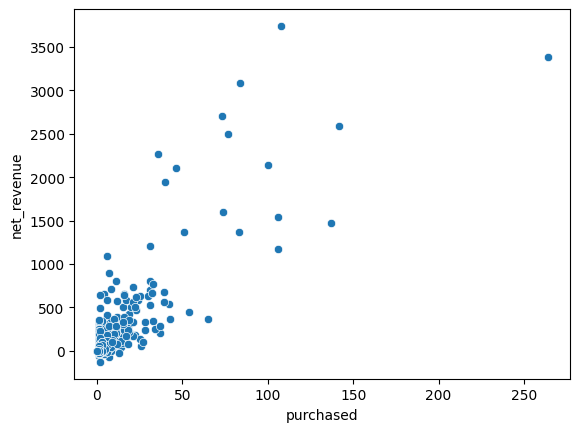

In [92]:
sns.scatterplot(df_cities,x='purchased',y='net_revenue')

In [93]:
df_cities.sort_values(by='net_revenue',ascending=False).head(n=10)

,address_city,purchased,net_revenue
1081,Dubai,108.0,3741.59
5910,東京,264.0,3383.37
3736,Singapore,84.0,3085.89
506,Boracay Island,73.0,2699.19
2414,Manila,142.0,2587.15
1623,Hong Kong,77.0,2494.56
4080,Tokyo,36.0,2262.91
292,Bangkok,100.0,2137.31
2283,London,46.0,2104.19
271,Bali,40.0,1946.65


In [94]:
df_cities_rates=pd.merge(df_cities,calculate_proportion(df_final,grp_metric='address_city',sum_metric='purchased',count_metric='offer_id').reset_index(),on='address_city')
df_cities_rates=df_cities_rates.rename(columns={0:'purchase_rate'})

In [95]:
df_cities_rates.sort_values(by=['net_revenue'],ascending=False).head(n=30)

,address_city,purchased,net_revenue,purchase_rate
1081,Dubai,108.0,3741.59,0.032306
5910,東京,264.0,3383.37,0.038858
3736,Singapore,84.0,3085.89,0.020508
506,Boracay Island,73.0,2699.19,0.021791
2414,Manila,142.0,2587.15,0.028594
1623,Hong Kong,77.0,2494.56,0.021413
4080,Tokyo,36.0,2262.91,0.015261
292,Bangkok,100.0,2137.31,0.013414
2283,London,46.0,2104.19,0.035770
271,Bali,40.0,1946.65,0.010145


### PF Refunds 

In [96]:
np.round(df_final[['deposit_total_usd','cap_total_usd','premium_percent','frozen_price_total_usd','stay_duration']].corr(),3)

,deposit_total_usd,cap_total_usd,premium_percent,frozen_price_total_usd,stay_duration
deposit_total_usd,1.000,0.203,0.089,0.599,0.585
cap_total_usd,0.203,1.000,0.011,0.113,0.163
premium_percent,0.089,0.011,1.000,-0.136,-0.011
frozen_price_total_usd,0.599,0.113,-0.136,1.000,0.315
stay_duration,0.585,0.163,-0.011,0.315,1.000
